In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

# 1. Initialize functions and generator for training and evaluation

In [2]:
def myGenerator(gen1, gen2):
    """Combine generators of imbalanced datasets into one.
    
    Args:
        gen1 (generator): First generator of image data split
            by classes
        gen2 (generator): Second generator of image data split
            by classes
        
    Returns:
        gen3 (generator): Generator that combines 2 generators
    """
    while True:
        img_data1, label1 = next(gen1)
        img_data2, label2 = next(gen2)
        if ((label1.shape[0] + label2.shape[0]) % 32) != 0:
            img_data1, label1 = next(gen1)
            img_data2, label2 = next(gen2)
        img_data_c = np.concatenate((img_data1, img_data2))

        label_size = label1.shape[1] + label2.shape[1]
        new_labels1 = np.zeros((label1.shape[0], label_size))
        new_labels1[:, :-label2.shape[1]] = label1
        new_labels2 = np.zeros((label2.shape[0], label_size))
        new_labels2[:, label1.shape[1]:] = label2

        labels_c = np.concatenate((new_labels1, new_labels2), axis=0)

        shuffler = np.random.permutation(labels_c.shape[0])
        labels_c_shuffled = labels_c[shuffler]
        img_data_c_shuffled = img_data_c[shuffler]

        yield img_data_c_shuffled, labels_c_shuffled

def plot_accuracy(history_obj, title):
    """Plots trained ML model accuracy scores.
    
    Args:
        history_df (obj): Output object from trained ML model 
        title (str): The desired title of the plot
        
    Returns:
        None
    """
    data_acc_df = pd.DataFrame({
        'epoch':[*range(1, len(
            history_obj.history['categorical_accuracy']) + 1)],
        'accuracy':history_obj.history['categorical_accuracy']}) 
    data_acc_df['Data'] = 'training'
    data_vacc_df = pd.DataFrame({
        'epoch':[*range(1, len(
            history_obj.history['val_categorical_accuracy']) + 1)],
        'accuracy':history_obj.history['val_categorical_accuracy']})
    data_vacc_df['Data'] = 'validation'
    data_m_df = pd.concat((data_acc_df, data_vacc_df), axis=0)

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=data_m_df, x='epoch', y='accuracy', hue='Data')
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title(title, fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim((0.1, 0.9))
    plt.show()
    
# Set up plot styling
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-notebook')

In [19]:
# Initialize training generator
train_datagen= ImageDataGenerator(
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1./255,
        fill_mode='nearest',
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=30,
        zoom_range=0.1,
        brightness_range=[0.7, 1.0])
train_generator_1 = train_datagen.flow_from_directory(
        'model_dataset/train/augment',
        target_size=(200, 200),
        batch_size=52,
        class_mode='categorical',
        shuffle=True,
        seed=15)
train_generator_2 = train_datagen.flow_from_directory(
        'model_dataset/train/no_augment',
        target_size=(200, 200),
        batch_size=12,
        class_mode='categorical',
        shuffle=True,
        seed=15)
train_generator = myGenerator(train_generator_1, train_generator_2)

# Initialize validation generator
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
        'model_dataset/validation',
        target_size=(200, 200),
        batch_size=32,
        shuffle=True,
        class_mode='categorical')

# Initialize test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory='model_dataset/test',
    target_size=(200, 200),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed=42)

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.
Found 75 images belonging to 5 classes.
Found 75 images belonging to 5 classes.


In [4]:
steps_per_epoch = 10

# 2. Evaluate CNN models

## Utilize a VGG-16 Architecture

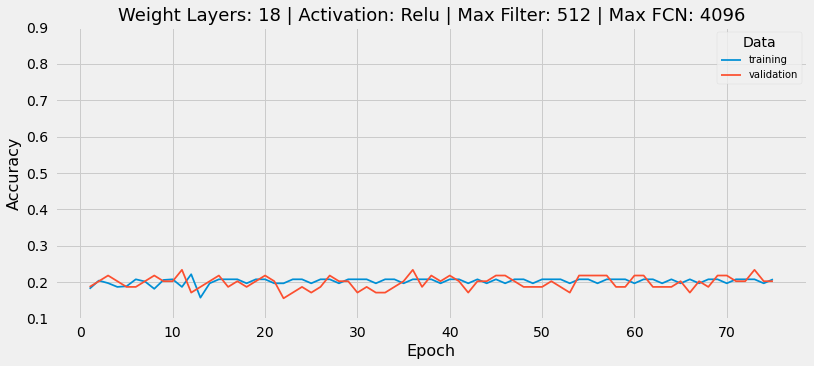

In [ ]:
# Weight Layers: 18 | Activation: Relu | Max Filter: 512 | Max FCN: 4096
vgg16 = models.Sequential()
vgg16.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
vgg16.add(layers.Conv2D(64, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(128, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(128, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(256, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(256, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(256, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(256, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(512, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(512, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(512, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(512, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dense(4096, activation='relu'))
vgg16.add(layers.Dropout(0.2))
vgg16.add(layers.Dense(4096, activation='relu'))
vgg16.add(layers.Dropout(0.2))
vgg16.add(layers.Dense(5, activation='softmax'))
vgg16.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['CategoricalAccuracy'])

# vgg16.summary()

history_vgg16 = vgg16.fit(train_generator, steps_per_epoch=steps_per_epoch,
                          epochs=75, validation_data=valid_generator,
                          validation_steps=2, verbose=0)
title = 'Weight Layers: 18 | Activation: Relu | Max Filter: 512 | Max FCN: 4096'
plot_accuracy(history_vgg16, title)

In [ ]:
# Weight Layers: 18 | Activation: Leaky Relu | Max Filter: 512 | Max FCN: 4096
vgg16 = models.Sequential()
vgg16.add(layers.Conv2D(64, (3, 3), 
                        activation=layers.LeakyReLU(alpha=0.3),
                        input_shape=(200, 200, 3)))
vgg16.add(layers.Conv2D(64, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(128, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.Conv2D(128, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(256, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.Conv2D(256, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.Conv2D(256, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.Conv2D(256, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(512, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.Conv2D(512, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.Conv2D(512, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.Conv2D(512, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dense(4096, activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.Dropout(0.2))
vgg16.add(layers.Dense(4096, activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.Dropout(0.2))
vgg16.add(layers.Dense(5, activation='softmax'))
vgg16.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['CategoricalAccuracy'])

# vgg16.summary()

history_vgg16 = vgg16.fit(train_generator, steps_per_epoch=steps_per_epoch,
                          epochs=75, validation_data=valid_generator,
                          validation_steps=2, verbose=0)
title = 'Weight Layers: 18 | Activation: Leaky Relu | Max Filter: 512 | Max FCN: 4096'
plot_accuracy(history_vgg16, title)

ResourceExhaustedError:  OOM when allocating tensor with shape[64,64,196,196] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential/max_pooling2d/MaxPool/MaxPoolGrad (defined at <ipython-input-5-ba523fc861c3>:34) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_2203]

Function call stack:
train_function


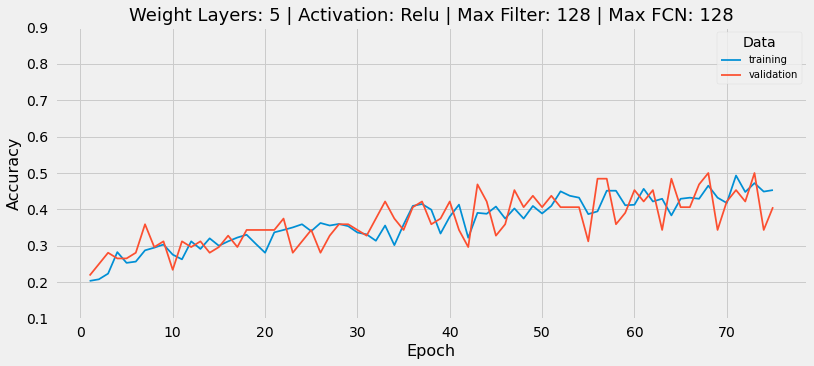

In [ ]:
# Weight Layers: 5 | Activation: Relu | Max Filter: 128 | Max FCN: 128
vgg16 = models.Sequential()
vgg16.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
vgg16.add(layers.Conv2D(64, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(128, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(128, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dense(128, activation='relu'))
vgg16.add(layers.Dropout(0.2))
vgg16.add(layers.Dense(5, activation = 'softmax'))
vgg16.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['CategoricalAccuracy'])

# vgg16.summary()

history_vgg16 = vgg16.fit(train_generator, steps_per_epoch=steps_per_epoch,
                          epochs=75, validation_data=valid_generator,
                          validation_steps=2, verbose=0)
title = 'Weight Layers: 5 | Activation: Relu | Max Filter: 128 | Max FCN: 128'
plot_accuracy(history_vgg16, title)

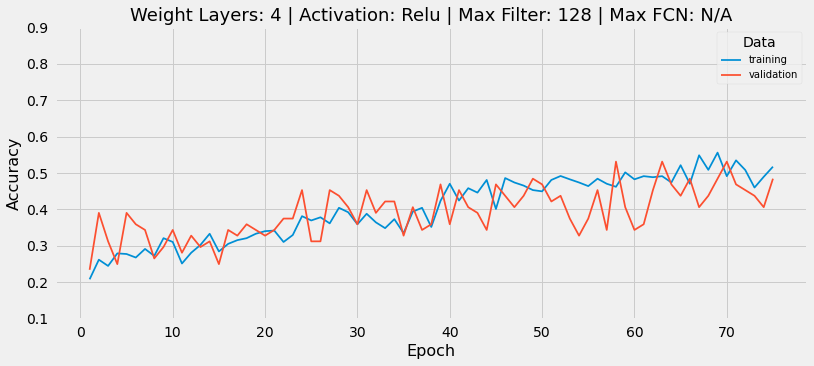

In [ ]:
# Weight Layers: 4 | Activation: Relu | Max Filter: 128 | Max FCN: N/A
vgg16 = models.Sequential()
vgg16.add(layers.Conv2D(64, (3, 3), activation='relu', 
                        input_shape=(200, 200, 3)))
vgg16.add(layers.Conv2D(64, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(128, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(128, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.2))
vgg16.add(layers.Dense(5, activation = 'softmax'))
vgg16.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['CategoricalAccuracy'])

# vgg16.summary()

history_vgg16 = vgg16.fit(train_generator, steps_per_epoch=steps_per_epoch,
                          epochs=75, validation_data=valid_generator, 
                          validation_steps=2, verbose=0)
title = 'Weight Layers: 4 | Activation: Relu | Max Filter: 128 | Max FCN: N/A'
plot_accuracy(history_vgg16, title)

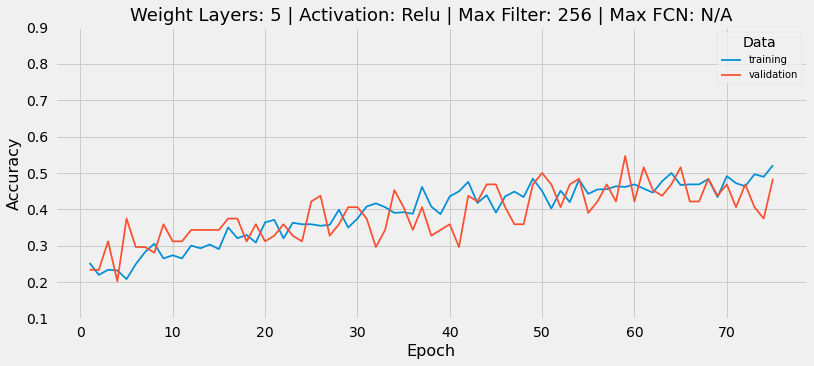

In [ ]:
# Weight Layers: 5 | Activation: Relu | Max Filter: 256 | Max FCN: N/A
vgg16 = models.Sequential()
vgg16.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
vgg16.add(layers.Conv2D(64, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(128, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(128, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(256, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.2))
vgg16.add(layers.Dense(5, activation='softmax'))
vgg16.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['CategoricalAccuracy'])

# vgg16.summary()

history_vgg16 = vgg16.fit(train_generator, steps_per_epoch=steps_per_epoch,
                          epochs=75, validation_data=valid_generator,
                          validation_steps=2, verbose=0)
title = 'Weight Layers: 5 | Activation: Relu | Max Filter: 256 | Max FCN: N/A'
plot_accuracy(history_vgg16,title)

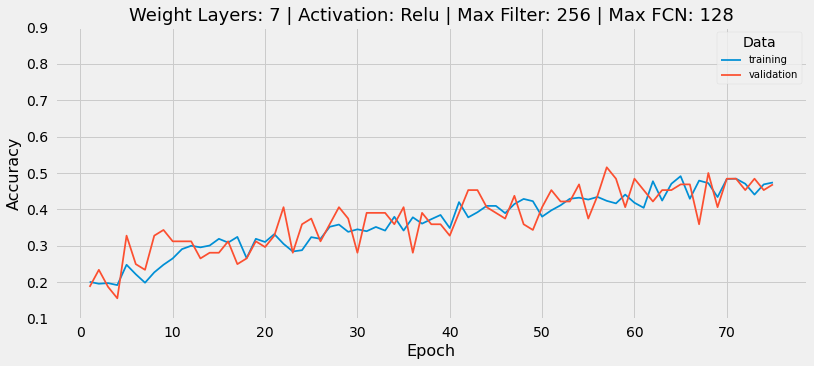

In [ ]:
# Weight Layers: 7 | Activation: Relu | Max Filter: 256 | Max FCN: 128
vgg16 = models.Sequential()
vgg16.add(layers.Conv2D(64, (3, 3), activation='relu', 
                        input_shape=(200, 200, 3)))
vgg16.add(layers.Conv2D(64, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(128, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(128, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(256, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(256, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dense(128,activation='relu'))
vgg16.add(layers.Dropout(0.2))
vgg16.add(layers.Dense(5,activation = 'softmax'))
vgg16.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['CategoricalAccuracy'])

# vgg16.summary()

history_vgg16 = vgg16.fit(train_generator, steps_per_epoch=steps_per_epoch,
                          epochs=75, validation_data=valid_generator,
                          validation_steps=2, verbose=0)
title = 'Weight Layers: 7 | Activation: Relu | Max Filter: 256 | Max FCN: 128'
plot_accuracy(history_vgg16, title)

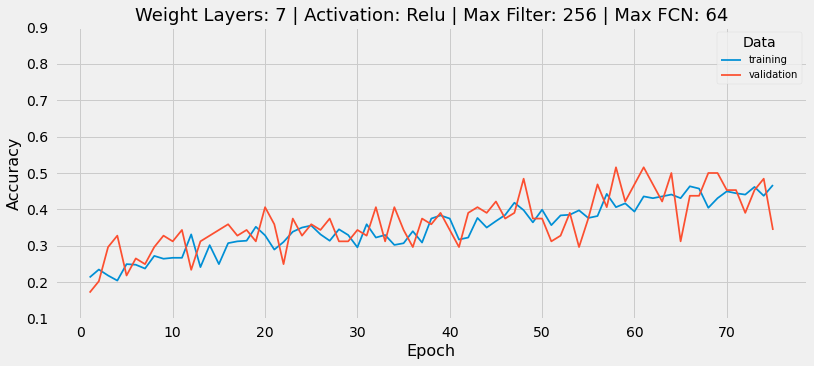

In [ ]:
# Weight Layers: 7 | Activation: Relu | Max Filter: 256 | Max FCN: 64
vgg16 = models.Sequential()
vgg16.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
vgg16.add(layers.Conv2D(64, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(128, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(128, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(256, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(256, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dense(64, activation='relu'))
vgg16.add(layers.Dropout(0.2))
vgg16.add(layers.Dense(5, activation = 'softmax'))
vgg16.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['CategoricalAccuracy'])

# vgg16.summary()

history_vgg16 = vgg16.fit(train_generator, steps_per_epoch=steps_per_epoch,
                          epochs=75, validation_data=valid_generator,
                          validation_steps=2, verbose=0)
title = 'Weight Layers: 7 | Activation: Relu | Max Filter: 256 | Max FCN: 64'
plot_accuracy(history_vgg16, title)

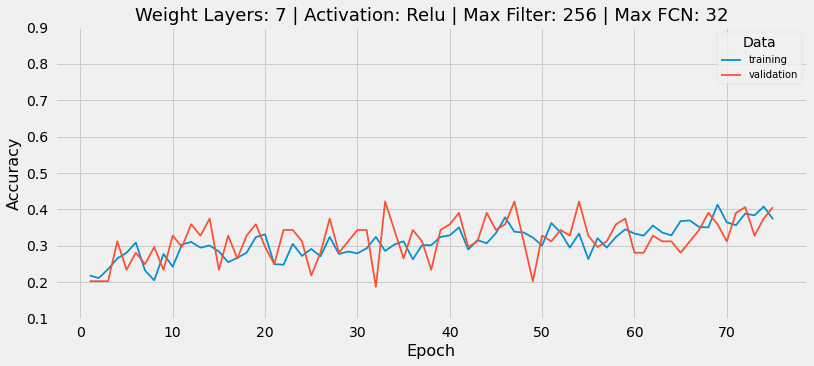

In [ ]:
# Weight Layers: 7 | Activation: Relu | Max Filter: 256 | Max FCN: 32
vgg16 = models.Sequential()
vgg16.add(layers.Conv2D(64, (3, 3), activation='relu', 
                        input_shape=(200, 200, 3)))
vgg16.add(layers.Conv2D(64, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(128, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(128, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(256, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(256, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dense(32,activation='relu'))
vgg16.add(layers.Dropout(0.2))
vgg16.add(layers.Dense(5,activation = 'softmax'))
vgg16.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['CategoricalAccuracy'])

# vgg16.summary()

history_vgg16 = vgg16.fit(train_generator, steps_per_epoch=steps_per_epoch,
                          epochs=75, validation_data=valid_generator,
                          validation_steps=2, verbose=0)
title = 'Weight Layers: 7 | Activation: Relu | Max Filter: 256 | Max FCN: 32'
plot_accuracy(history_vgg16, title)

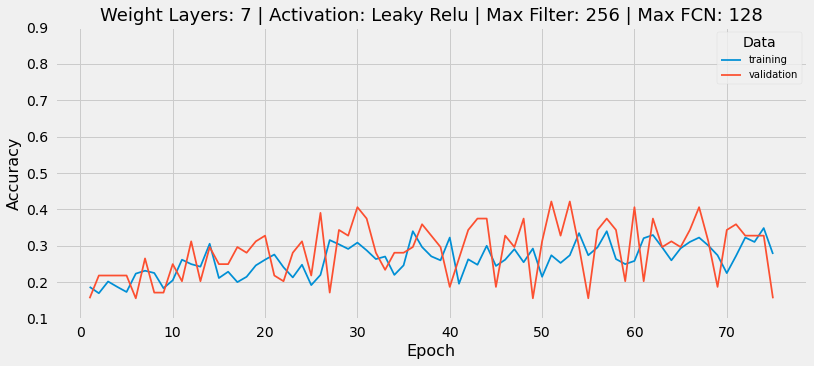

In [ ]:
# Weight Layers: 7 | Activation: Leaky Relu | Max Filter: 256 | Max FCN: 128
vgg16 = models.Sequential()
vgg16.add(layers.Conv2D(64, (3, 3), 
                        activation=layers.LeakyReLU(alpha=0.3), 
                        input_shape=(200, 200, 3)))
vgg16.add(layers.Conv2D(64, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(128, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.Conv2D(128, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(256, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.Conv2D(256, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dense(128, activation=layers.LeakyReLU(alpha=0.3)))
vgg16.add(layers.Dropout(0.2))
vgg16.add(layers.Dense(5, activation='softmax'))
vgg16.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['CategoricalAccuracy'])

# vgg16.summary()

history_vgg16 = vgg16.fit(train_generator, steps_per_epoch=steps_per_epoch,
                          epochs=75, validation_data=valid_generator,
                          validation_steps=2, verbose=0)
title = 'Weight Layers: 7 | Activation: Leaky Relu | Max Filter: 256 | Max FCN: 128'
plot_accuracy(history_vgg16, title)

## Utilize Densenet Architecture

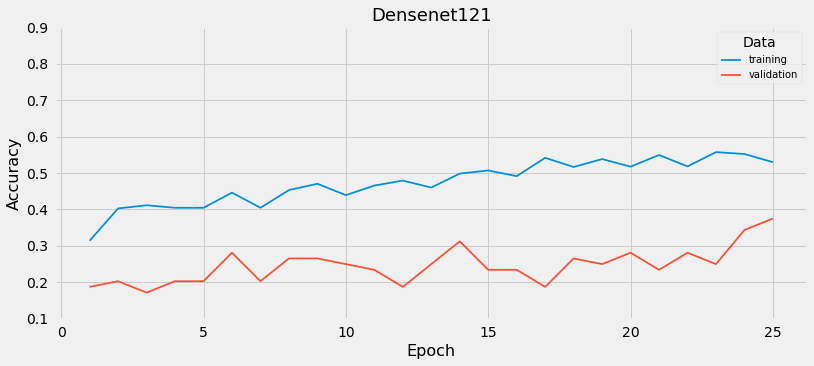

In [ ]:
dn121 = tf.keras.applications.DenseNet121(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(200, 200, 3),
    pooling=None,
    classes=5,
)
dn121.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['CategoricalAccuracy'])
history_dn121 = dn121.fit(train_generator, steps_per_epoch=steps_per_epoch,
                          epochs=25, validation_data=valid_generator,
                          validation_steps=2, verbose=0)
title = 'Densenet121'
plot_accuracy(history_dn121, title)

## Utilize EfficientNet Architecture

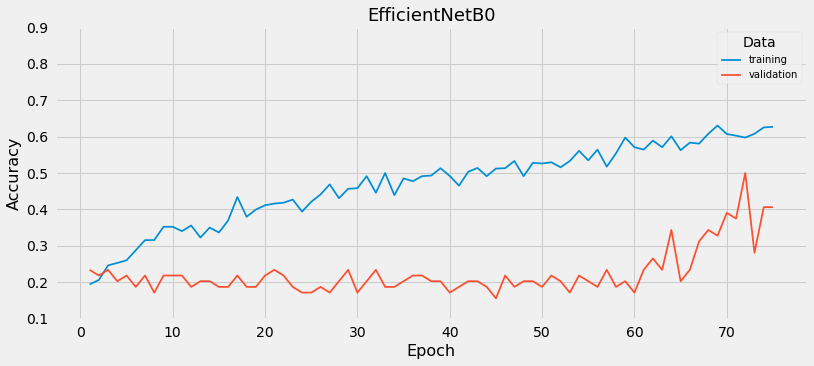

In [ ]:
enet = tf.keras.applications.EfficientNetB0(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(200,200,3),
    pooling=None,
    classes=5,
    classifier_activation="softmax",
)
enet.compile(loss='categorical_crossentropy', optimizer='rmsprop',
             metrics=['CategoricalAccuracy'])
history_enet = enet.fit(train_generator,steps_per_epoch=steps_per_epoch,
                        epochs=75, validation_data=valid_generator,
                        validation_steps=2,verbose=0)
title = 'EfficientNetB0'
plot_accuracy(history_enet, title)

# 3. Evaluate the best CNN model

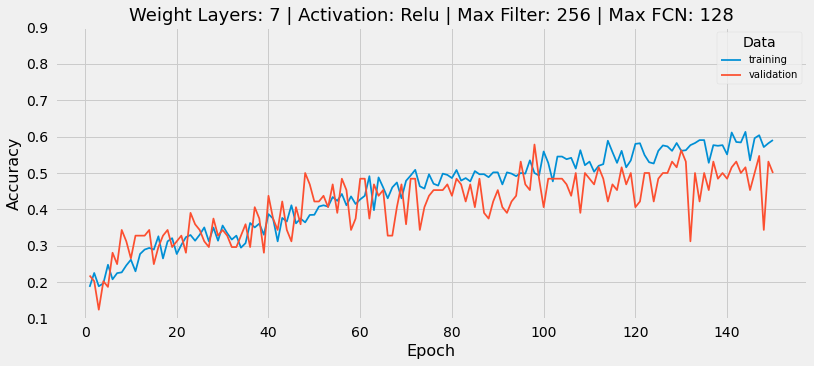

In [5]:
# Weight Layers: 7 | Activation: Relu | Max Filter: 256 | Max FCN: 128
vgg16 = models.Sequential()
vgg16.add(layers.Conv2D(64, (3, 3), activation='relu', 
                        input_shape=(200, 200, 3)))
vgg16.add(layers.Conv2D(64, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(128, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(128, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Conv2D(256, (3, 3), activation='relu'))
vgg16.add(layers.Conv2D(256, (3, 3), activation='relu'))
vgg16.add(layers.MaxPooling2D((2, 2)))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dense(128, activation='relu'))
vgg16.add(layers.Dropout(0.2))
vgg16.add(layers.Dense(5, activation = 'softmax'))
vgg16.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['CategoricalAccuracy'])
# vgg16.summary()

history_vgg16 = vgg16.fit(train_generator, steps_per_epoch=steps_per_epoch,
                          epochs=150, validation_data=valid_generator,
                          validation_steps=2, verbose=0)
title = 'Weight Layers: 7 | Activation: Relu | Max Filter: 256 | Max FCN: 128'
plot_accuracy(history_vgg16, title)

In [38]:
c_labels = list(test_generator.class_indices.keys())

# Obtain non-generator training data and check for overfitting
for i in range(steps_per_epoch):
    (X_sub, y_sub) = next(train_generator)
    y_sub = np.argmax(y_sub, axis=1)
    if i == 0:
        X_train = X_sub.copy()
        y_train = y_sub.copy()
    else:
        X_train = np.append(X_train, X_sub, axis=0)
        y_train = np.append(y_train, y_sub, axis=0)

y_train_pred = np.argmax(vgg16.predict(X_train), axis=1)
print(classification_report(y_train, y_train_pred, target_names=c_labels))

               precision    recall  f1-score   support

  dried_basil       0.40      0.27      0.32        15
dried_oregano       0.30      0.40      0.34        15
dried_parsley       0.86      0.40      0.55        15
  dried_thyme       0.25      0.27      0.26        15
       random       0.59      0.87      0.70        15

     accuracy                           0.44        75
    macro avg       0.48      0.44      0.43        75
 weighted avg       0.48      0.44      0.43        75



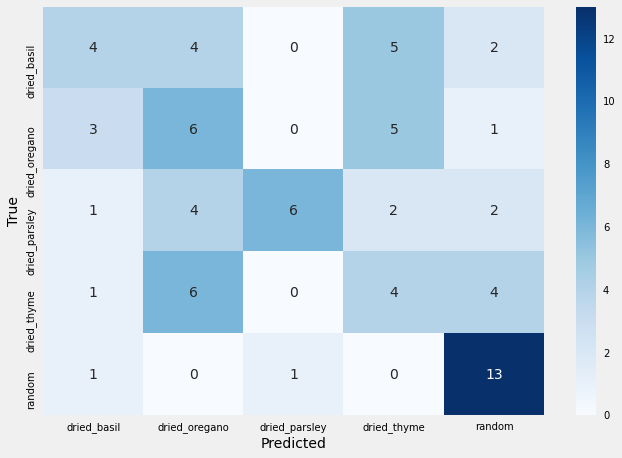

In [40]:
# Obtain non-generator test data
y_test = test_generator.classes
for i in range(test_generator.samples):
    (X_sub, _) = next(test_generator)
    if i == 0:
        X_test = X_sub.copy()
    else:
        X_test = np.append(X_test, X_sub, axis=0)

y_test_pred = np.argmax(vgg16.predict(X_test), axis=1)
print(classification_report(y_test, y_test_pred, target_names=c_labels))

# Evaluate model
cm = confusion_matrix(y_test, y_test_pred)
df_cm = pd.DataFrame(cm, index=c_labels, columns=c_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.ylabel('True', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.show()